In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# Decomposing signals in components (Maxtrix factorization)

To reduce the dimensionality and still keep statstical signals and patterns from our dataset matrix $X$, which is 
$[n_{samples}, n_{dimensions}]$.

We often can use *matrix factorixation* methods to decompose $X$ into various forms, each of which has various mathematical properties.

One of the most common factorizations that applies well here, is Singular value decomposition (SVD) which generalizes the eigendecomposition of a square normal matrix to any $m\times n$ matrix via an extension of the polar decomposition.

$$ X = M = U\Sigma V^* $$

Where $U$ is an $m \times m$ real unitary matrix, $\Sigma$ is an $m \times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ is an $n \times n$ real unitary matrix. $U$ and $V=V^*$ are real orthonormal matrices.

The diagonal entries $\sigma_i=\Sigma_{i i}$ of $\Sigma$ are known as the *singular value's* of $X$. The number of non-zero singular values is equal to the rank of $X$. The columns of $U$ and the columns of $V$ are called the *left-singular vectors* and *right-singular vectors* of $X$, respectively. The SVD is not unique. It is always possible to choose the decomposition so that the singular values $\Sigma_{i i}$are in descending order.

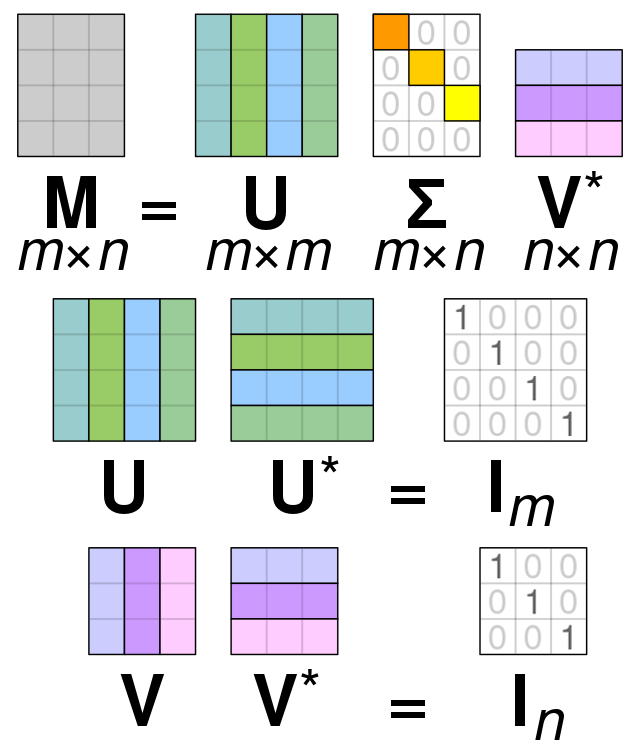

We can use this form to reduce the dimensionality of $X$, by setting the $s$ smallest *singular value's* to $0$, thus we can eliminate the corresponding $s$ columns of $U$ and $V$. This would then form a new $X'$ that has the dimensions of $[n_{samples}, n_{dimensions - s}]$. This is what the model `TruncatedSVD` tries to do.

## Principal Component Analysis

Principal component analysis (PCA) uses this orthogonal transformation to convert a set of observations of possibly correlated variables $X$ into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing $n$ observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

This centers each sample in $X$ to have a mean of $0$, then applies the SVD decomposition. This results in a very useful property that the variance of the data in any low-dimensional representation is maximized. The eigenvectors or *right-singular vectors* that correspond to the largest eigenvalues or *singular value's* (the principal components) can now be used to reconstruct a large fraction of the variance of the original data.

We use this `sklearn` to reduce the dimension of the $X$ in such a way that the variance of the data in the low-dimensional representation is maximized. Which can be useful for plotting, via reducing the $X$ to $2d$ or $3d$.


Components : [[-0.97824443 -0.2074556 ]
 [-0.2074556   0.97824443]]
Explained Variance : [12.32266623  0.46939016]
Mean : [20.23416889 20.04390541]


[]

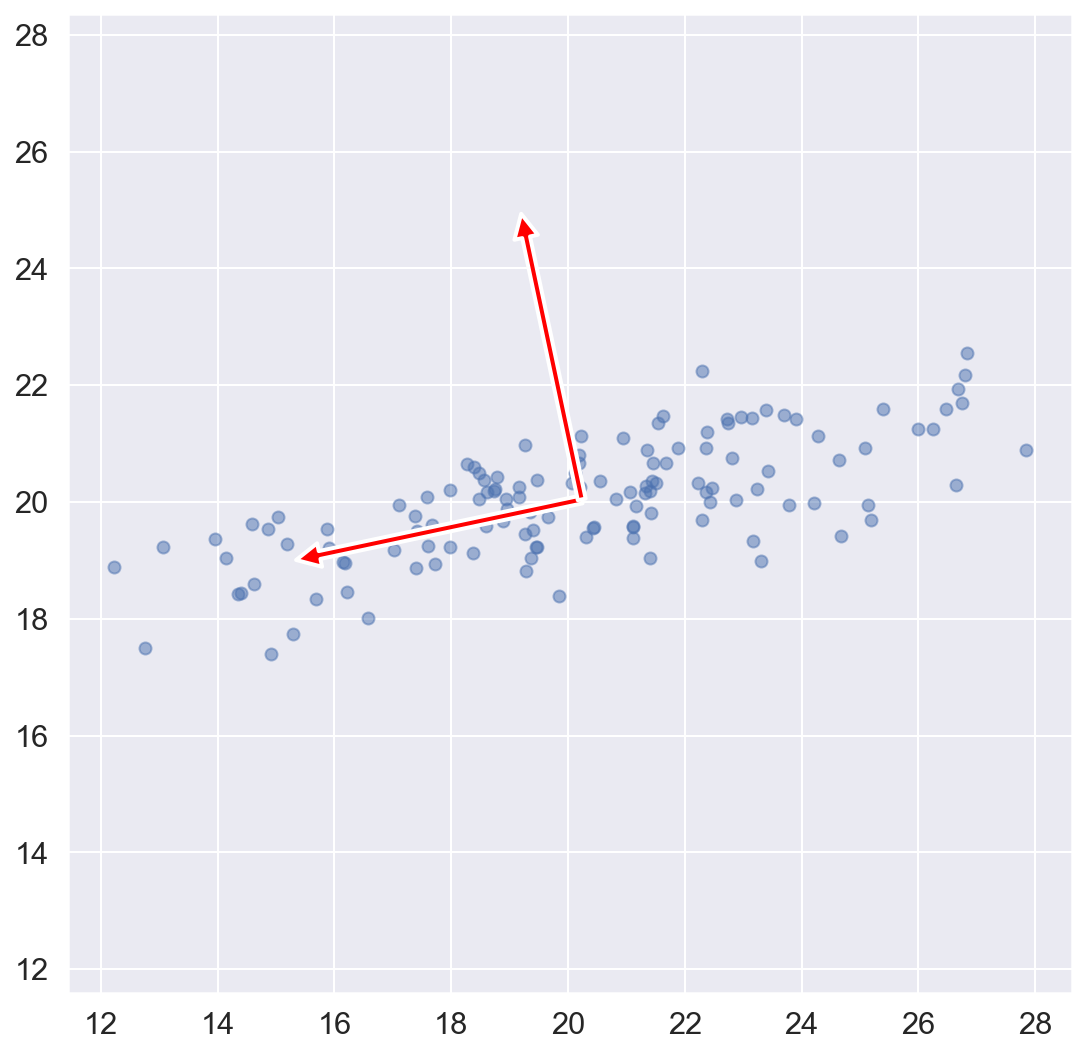

In [18]:
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.decomposition import PCA

def draw_vector(v0, v1, ax):
    arrowprops=dict(linewidth=2,
                    shrinkA=0,
                    shrinkB=0,
                    facecolor='red')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

n_samples = 128
np.random.seed(0)

C = np.array([[0., -0.7], [3.5, .7]])
X_train = np.dot(np.random.randn(n_samples, 2), C) + np.array([20, 20])

fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5)

pca = PCA(n_components=2)
pca.fit(X_train)

print('Components : {}'.format(pca.components_))
print('Explained Variance : {}'.format(pca.explained_variance_))
print('Mean : {}'.format(pca.mean_))

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 5
    draw_vector(pca.mean_, pca.mean_ + v, ax)
ax.axis('equal')
ax.plot()

[]

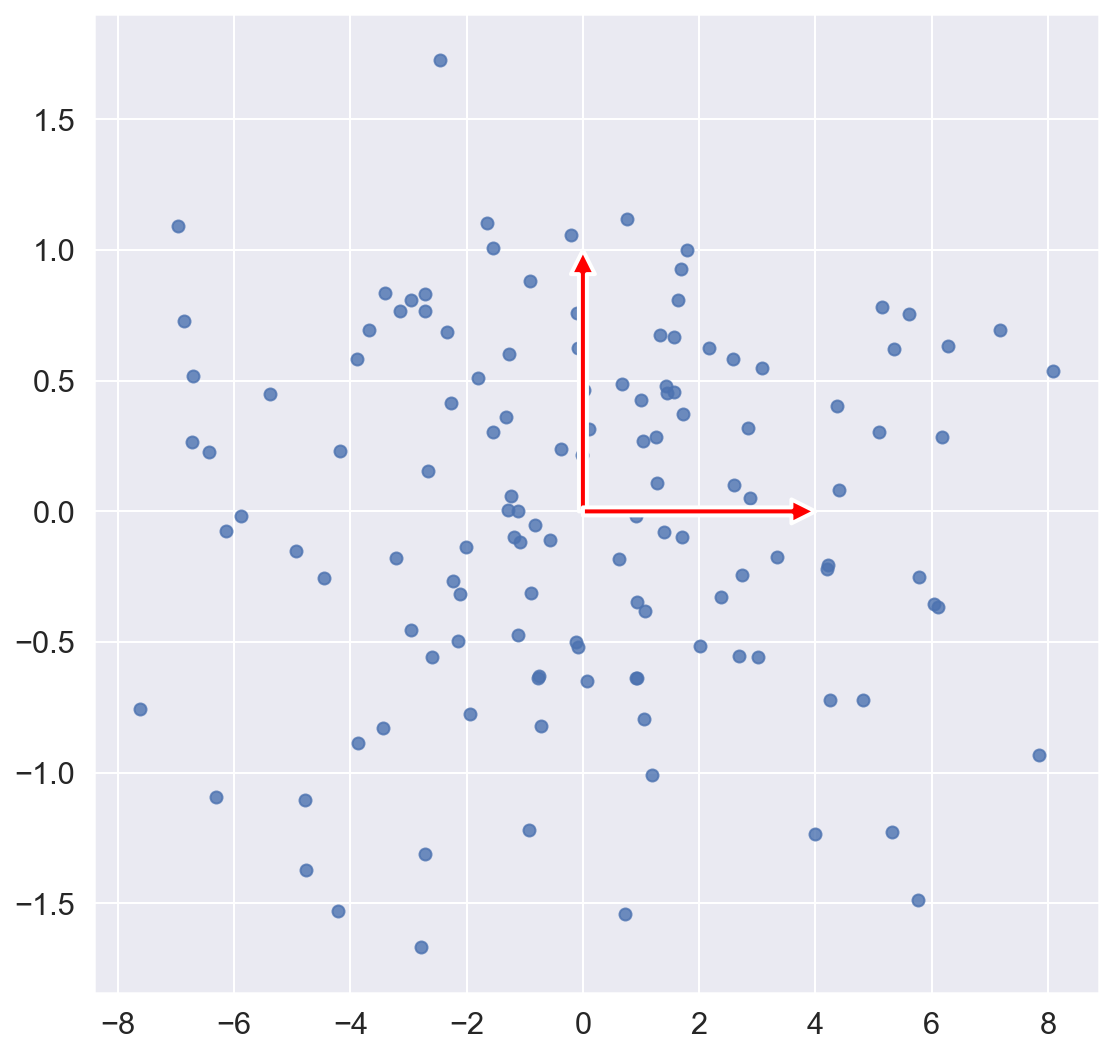

In [23]:
X_transformed = pca.transform(X_train)
fig, ax = plt.subplots()
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], alpha=0.8)
mean = np.array([0, 0])
draw_vector(mean, mean + np.array([0,1]), ax)
draw_vector(mean, mean + np.array([4,0]), ax)
ax.plot()

Size of X' : (128, 1)


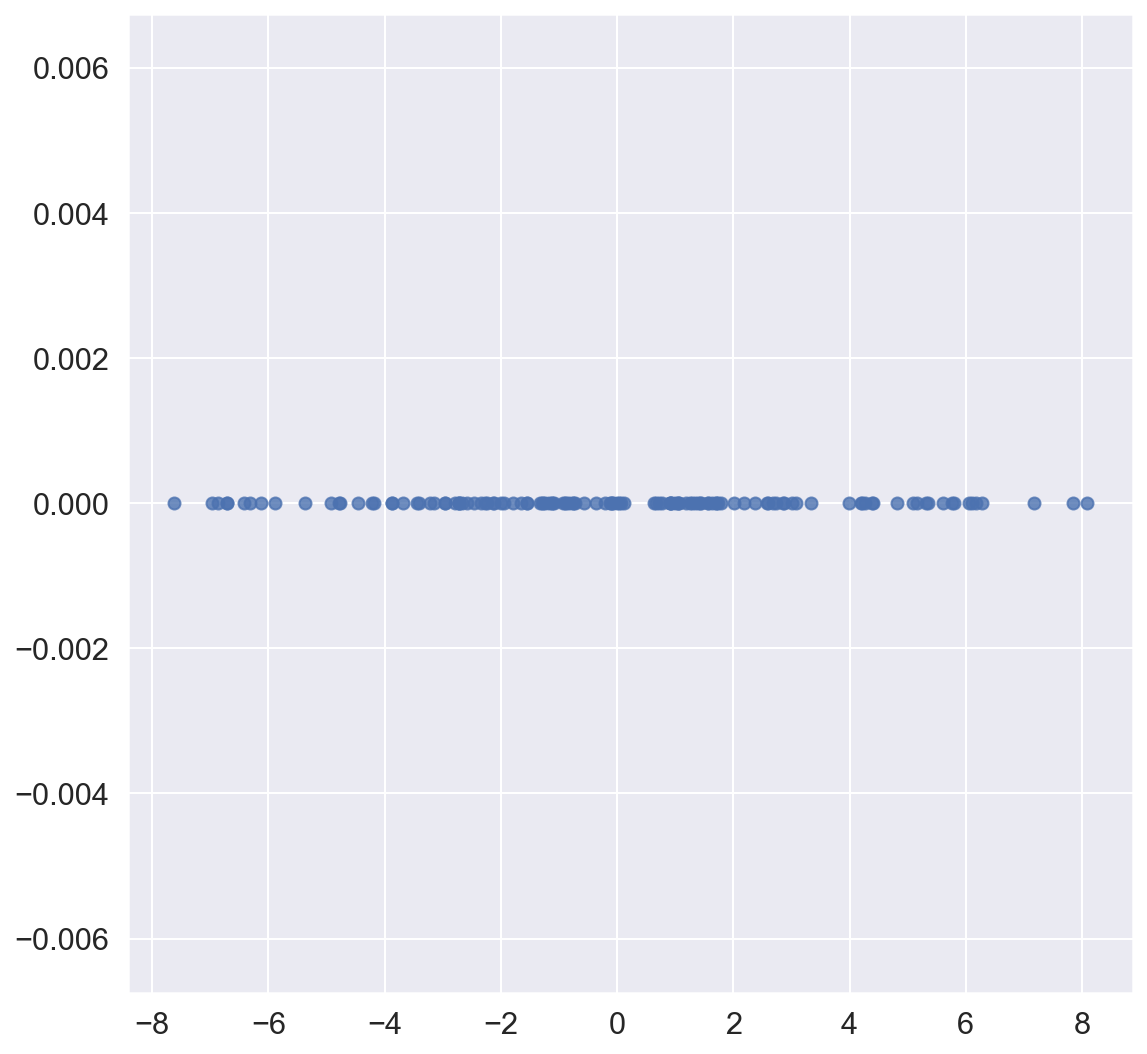

In [43]:
pca = PCA(n_components=1)
pca.fit(X_train)
X_pca = pca.transform(X_train)
plt.scatter(X_pca, np.zeros(len(X_pca)), alpha=0.8)
plt.plot()

print("Size of X' : {}".format(X_pca.shape))

[]

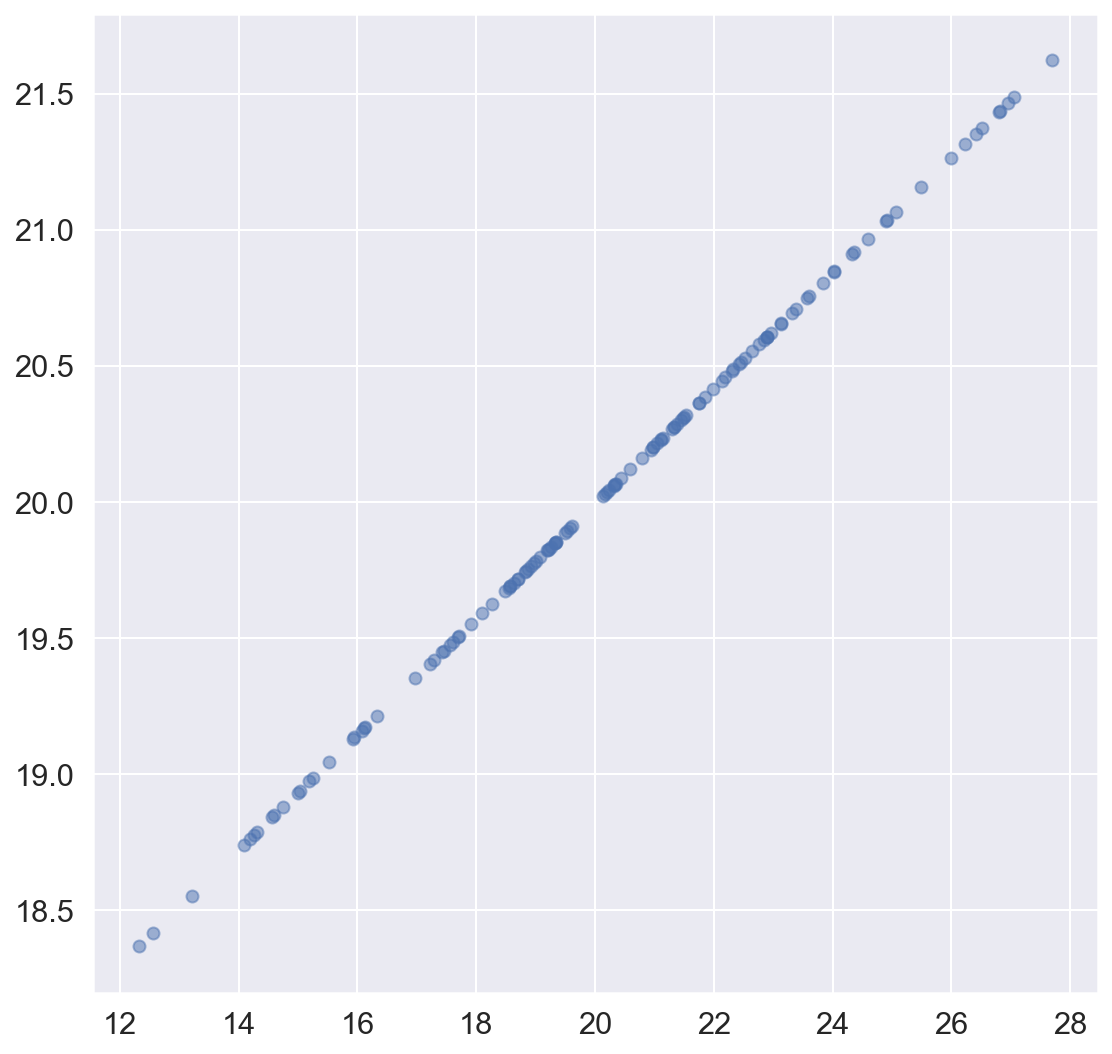

In [44]:
X_pca_inverse = pca.inverse_transform(X_pca)
fig, ax = plt.subplots()
ax.scatter(X_pca_inverse[:, 0], X_pca_inverse[:, 1], alpha=0.5)
ax.plot()

The optional keyword argument `whiten=True` makes it possible to project the data onto the singular space while scaling each component to unit variance. 

The optional keyword argument `svd_solver` which can take `{'auto', 'full', 'arpack', 'randomized'}`. Where for efficieny on large datasets we can use `randomized` when we are dropping the dimension significantly (Which limits the computation to an approximation of the singular vectors).

## Incremental PCA

`PCA` only supports batch processing, which means all of the data to be processed must fit in main memory which can be an issue. The `IncrementalPCA` object uses a different form of processing and allows for partial computations which almost exactly match the results of PCA while processing the data in a minibatch fashion. `IncrementalPCA` makes it possible to implement out-of-core Principal Component Analysis either by:
* Using its `partial_fit` method on chunks of data fetched sequentially from the local hard drive or a network database.
* Calling its fit method on a sparse matrix or a memory mapped file using `numpy.memmap`.

`IncrementalPCA` only stores estimates of component and noise variances, in order update `explained_variance_ratio_` incrementally. This is why memory usage depends on the number of samples per batch, rather than the number of samples to be processed in the dataset.

As in `PCA`, `IncrementalPCA` centers but does not scale the input data for each feature before applying SVD.

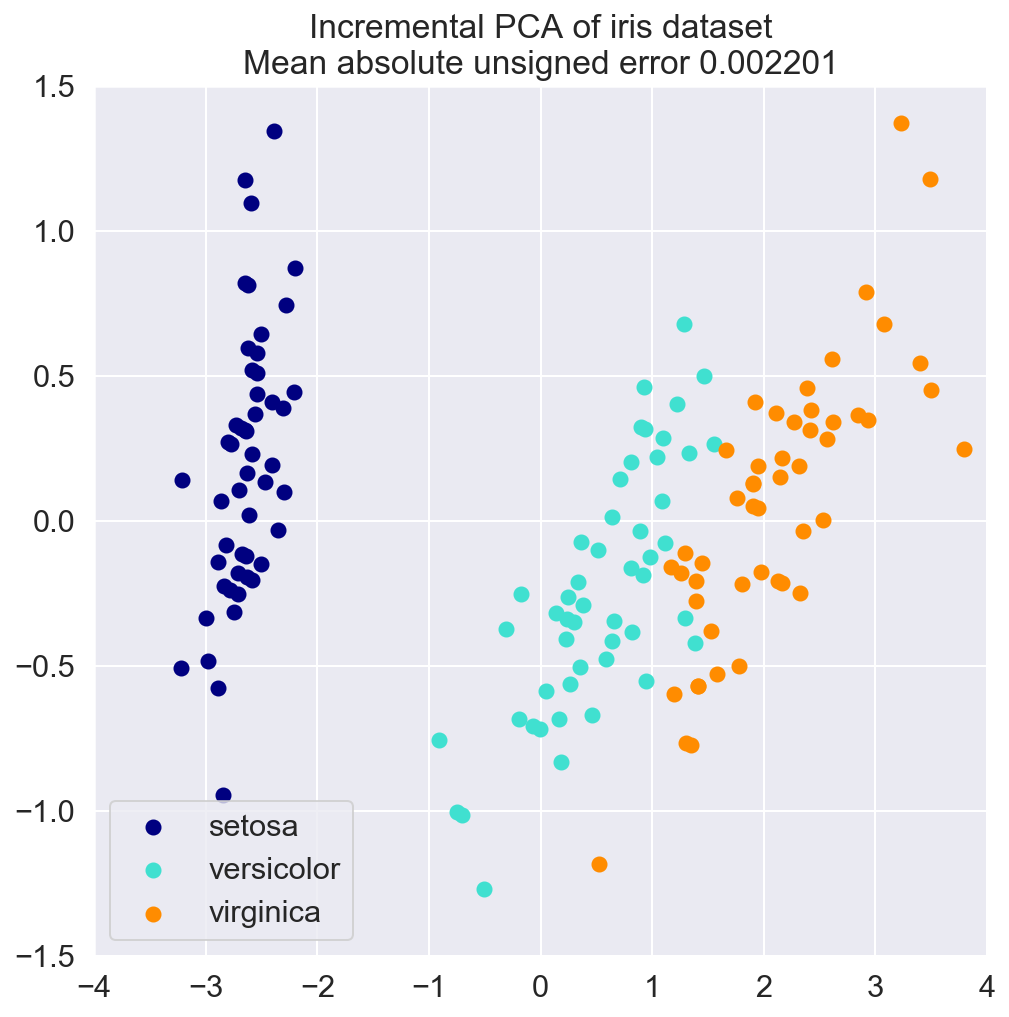

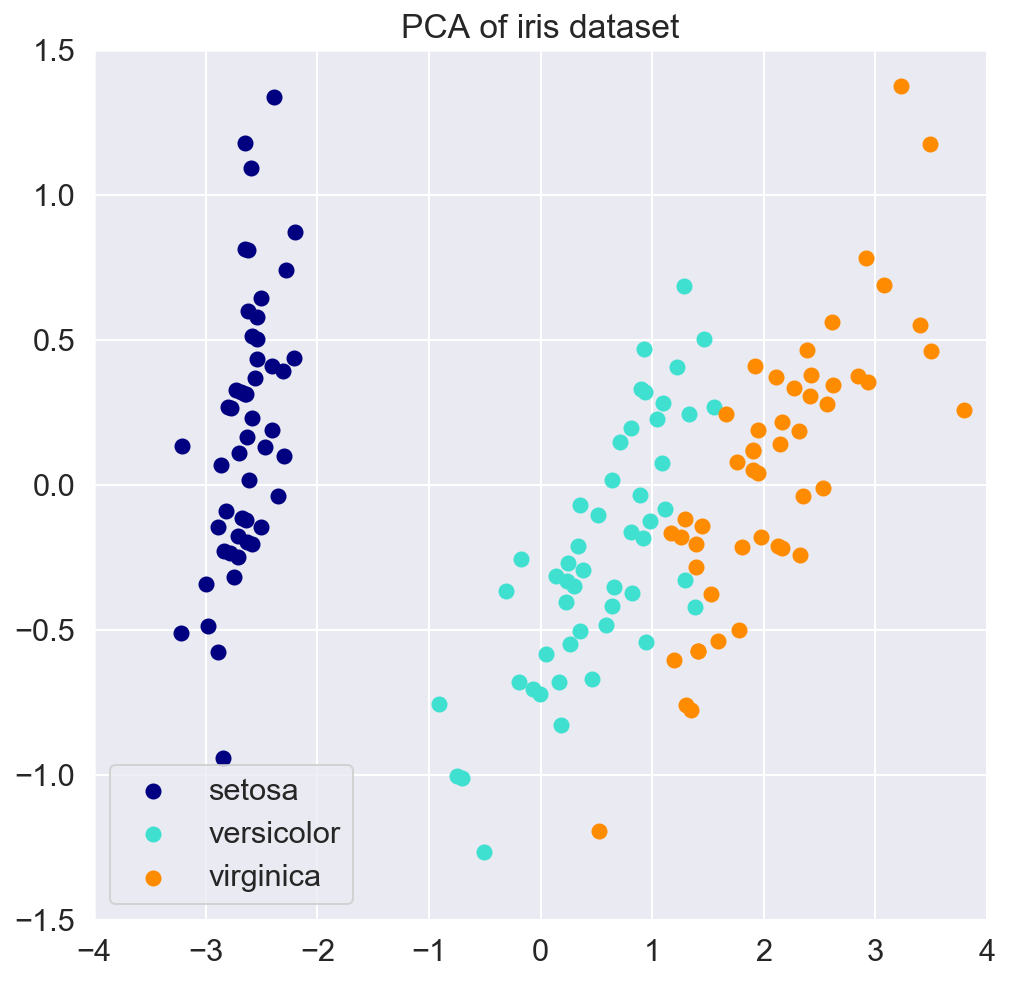

In [33]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA

iris = load_iris()
X = iris.data
y = iris.target

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ['navy', 'turquoise', 'darkorange']

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                    color=color, lw=2, label=target_name)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

## Kernel PCA

`KernelPCA` is an extension of PCA which achieves non-linear dimensionality reduction through the use of `sklearn`'s supported kernels. It has many applications including denoising, compression and structured prediction (kernel dependency estimation). KernelPCA supports both `transform` and `inverse_transform`.

/Users/samholt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


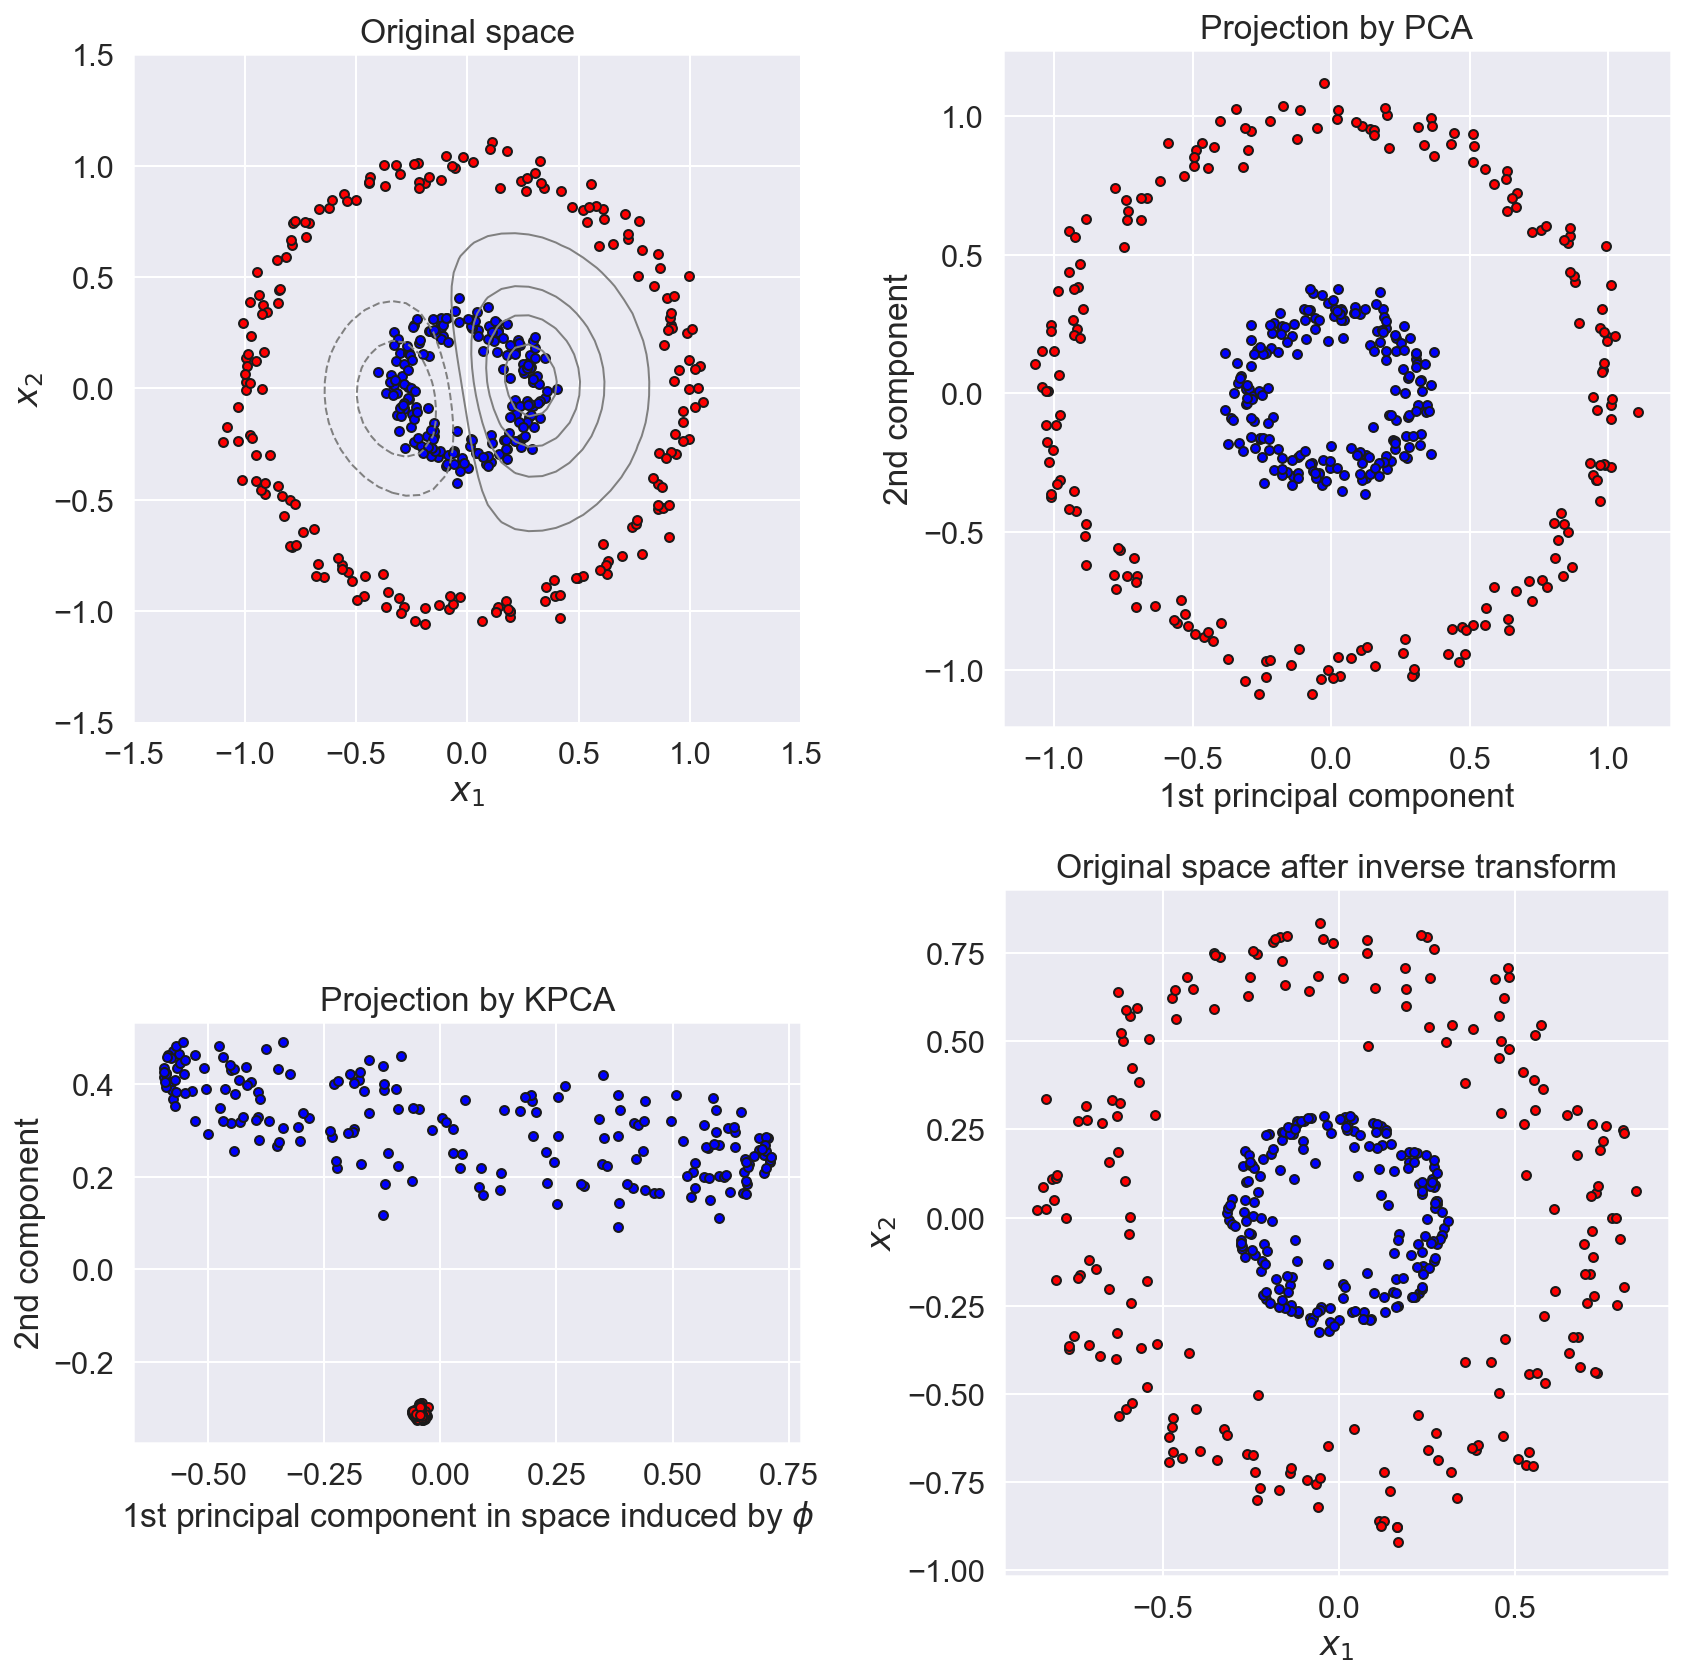

In [48]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot results

plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

In the example above, Kernel PCA is able to find a projection of the data that makes data linearly separable.

## Truncated SVD (Singular Value Decomposition)

`TruncatedSVD` implements a variant of singular value decomposition (SVD) that only computes the $k$ largest singular values, where $k$ is a user-specified parameter.

`TruncatedSVD` applied to the training samples $X$ produces a low-rank approximation $X_k$ :

$$ X \approx X_k = U_k \Sigma_k V_k^\top $$

After this operation, $ U_k \Sigma_k^\top $ is the transformed training set with $k$ features (called `n_components`)

To transform a test set $X$ so that the data is rotated so that it is aligned with the orthogonal *right-singular vectors*:

$$ X' = X V_k $$

## Dictionary learning

### Sparse dictionary learning

Sparse dictionary learning aims at finding a sparse representation of the input data (also known as sparse coding) in the form of a linear combination of basic elements as well as those basic elements themselves. These elements are called atoms and they compose a dictionary. Atoms in the dictionary are not required to be orthogonal, and they may be an over-complete spanning set. This problem setup also allows the dimensionality of the signals being represented to be higher than the one of the signals being observed. The above two properties lead to having seemingly redundant atoms that allow multiple representations of the same signal but also provide an improvement in sparsity and flexibility of the representation.

One of the most important applications of sparse dictionary learning is in the field of compressed sensing or signal recovery. In compressed sensing, a high-dimensional signal can be recovered with only a few linear measurements provided that the signal is sparse or nearly sparse. Since not all signals satisfy this sparsity condition, it is of great importance to find a sparse representation of that signal such as the wavelet transform or the directional gradient of a rasterized matrix. Once a matrix or a high dimensional vector is transferred to a sparse space, different recovery algorithms like basis pursuit, CoSaMP or fast non-iterative algorithms can be used to recover the signal.

One of the key principles of dictionary learning is that the dictionary has to be inferred from the input data. The emergence of sparse dictionary learning methods was stimulated by the fact that in signal processing one typically wants to represent the input data using as few components as possible. Before this approach the general practice was to use predefined dictionaries (such as fourier or wavelet transforms). However, in certain cases a dictionary that is trained to fit the input data can significantly improve the sparsity, which has applications in data decomposition, compression and analysis and has been used in the fields of image denoising and classification, video and audio processing. Sparsity and overcomplete dictionaries have immense applications in image compression, image fusion and inpainting.

The `SparseCoder` object is an estimator
that can be used to transform signals into sparse linear combination of
atoms from a fixed, precomputed dictionary such as a discrete wavelet
basis. This object therefore does not implement a `fit` method. The
transformation amounts to a sparse coding problem: finding a
representation of the data as a linear combination of as few dictionary
atoms as possible. All variations of dictionary learning implement the
following transform methods, controllable via the `transform_method`
initialization parameter:

-   Orthogonal matching pursuit (`omp`)
-   Least-angle regression (`least_angle_regression`)
-   Lasso computed by least-angle regression
-   Lasso using coordinate descent (`lasso`)
-   Thresholding

Thresholding is very fast but it does not yield accurate
reconstructions. They have been shown useful in literature for
classification tasks. For image reconstruction tasks, orthogonal
matching pursuit yields the most accurate, unbiased reconstruction.

The dictionary learning objects offer, via the `split_code` parameter,
the possibility to separate the positive and negative values in the
results of sparse coding. This is useful when dictionary learning is
used for extracting features that will be used for supervised learning,
because it allows the learning algorithm to assign different weights to
negative loadings of a particular atom, from to the corresponding
positive loading.

The split code for a single sample has length `2 * n_components` and is
constructed using the following rule: First, the regular code of length
`n_components` is computed. Then, the first `n_components` entries of
the `split_code` are filled with the positive part of the regular code
vector. The second half of the split code is filled with the negative
part of the code vector, only with a positive sign. Therefore, the
split\_code is non-negative.

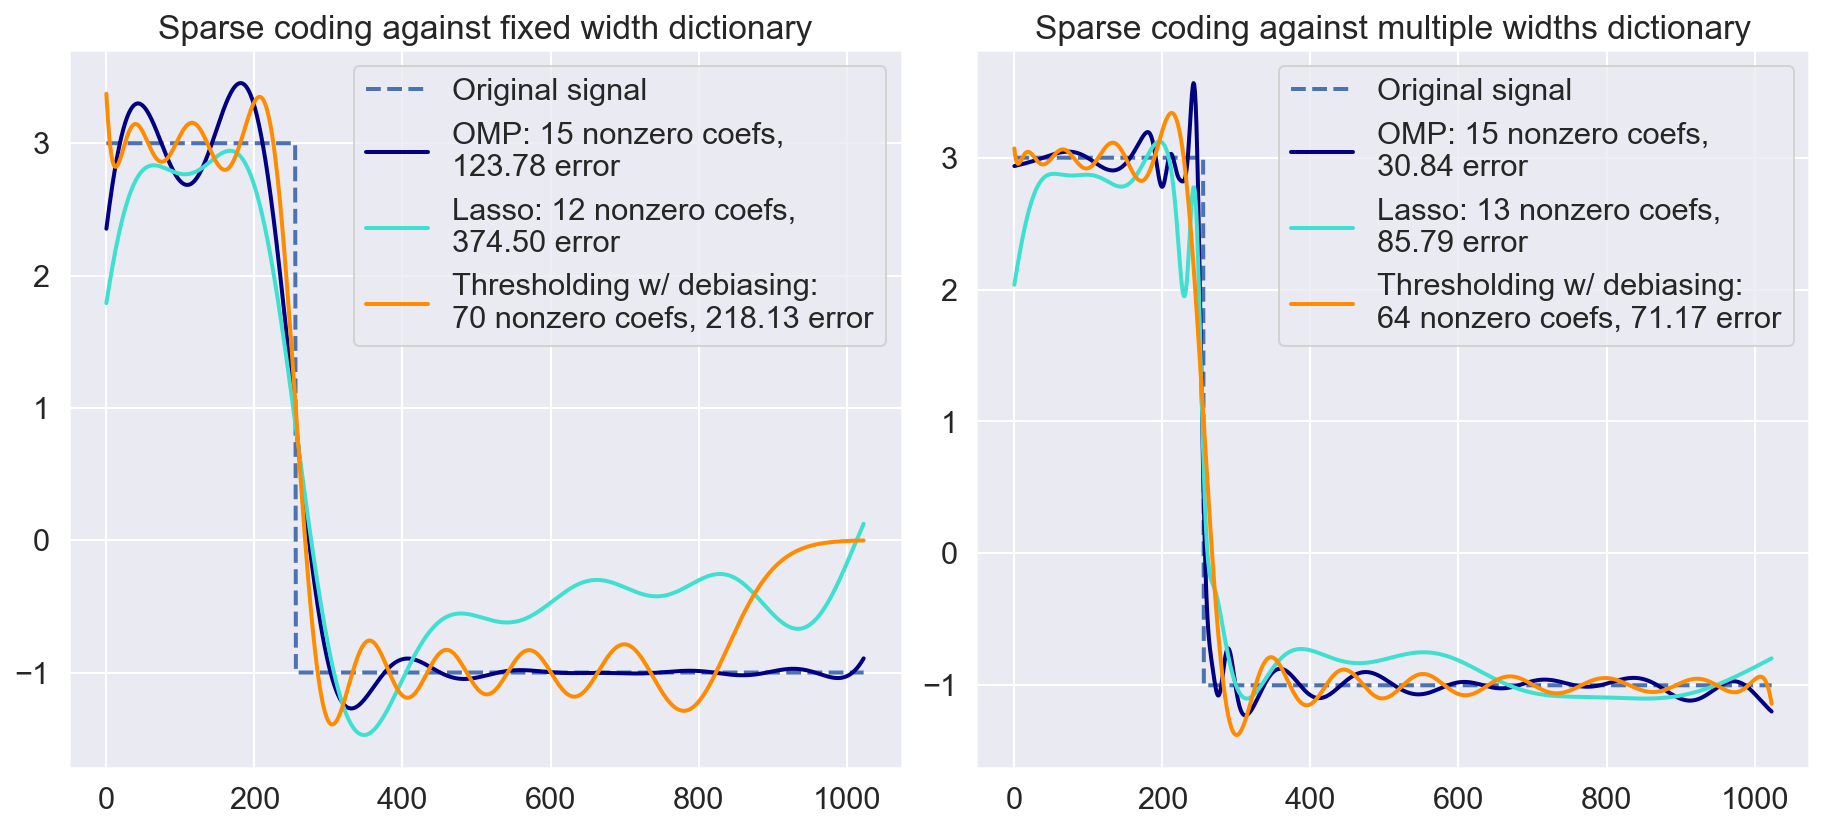

In [50]:
from distutils.version import LooseVersion

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import SparseCoder


def ricker_function(resolution, center, width):
    """Discrete sub-sampled Ricker (Mexican hat) wavelet"""
    x = np.linspace(0, resolution - 1, resolution)
    x = ((2 / (np.sqrt(3 * width) * np.pi ** .25))
         * (1 - (x - center) ** 2 / width ** 2)
         * np.exp(-(x - center) ** 2 / (2 * width ** 2)))
    return x


def ricker_matrix(width, resolution, n_components):
    """Dictionary of Ricker (Mexican hat) wavelets"""
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D ** 2, axis=1))[:, np.newaxis]
    return D


resolution = 1024
subsampling = 3  # subsampling factor
width = 100
n_components = resolution // subsampling

# Compute a wavelet dictionary
D_fixed = ricker_matrix(width=width, resolution=resolution,
                        n_components=n_components)
D_multi = np.r_[tuple(ricker_matrix(width=w, resolution=resolution,
                      n_components=n_components // 5)
                for w in (10, 50, 100, 500, 1000))]

# Generate a signal
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3.
y[np.logical_not(first_quarter)] = -1.

# List the different sparse coding methods in the following format:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)
estimators = [('OMP', 'omp', None, 15, 'navy'),
              ('Lasso', 'lasso_lars', 2, None, 'turquoise'), ]
lw = 2
# Avoid FutureWarning about default value change when numpy >= 1.14
lstsq_rcond = None if LooseVersion(np.__version__) >= '1.14' else -1

plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(zip((D_fixed, D_multi),
                                         ('fixed width', 'multiple widths'))):
    plt.subplot(1, 2, subplot + 1)
    plt.title('Sparse coding against %s dictionary' % title)
    plt.plot(y, lw=lw, linestyle='--', label='Original signal')
    # Do a wavelet approximation
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=n_nonzero,
                            transform_alpha=alpha, transform_algorithm=algo)
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(x, color=color, lw=lw,
                 label='%s: %s nonzero coefs,\n%.2f error'
                 % (title, density, squared_error))

    # Soft thresholding debiasing
    coder = SparseCoder(dictionary=D, transform_algorithm='threshold',
                        transform_alpha=20)
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=lstsq_rcond)
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    plt.plot(x, color='darkorange', lw=lw,
             label='Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error'
             % (len(idx), squared_error))
    plt.axis('tight')
    plt.legend(shadow=False, loc='best')
plt.subplots_adjust(.04, .07, .97, .90, .09, .2)
plt.show()

#### /\ Example : Sparse coding with a precomputed dictionary

Transform a signal as a sparse combination of Ricker wavelets. This example visually compares different sparse coding methods using the sklearn.decomposition.SparseCoder estimator. The Ricker (also known as Mexican hat or the second derivative of a Gaussian) is not a particularly good kernel to represent piecewise constant signals like this one. It can therefore be seen how much adding different widths of atoms matters and it therefore motivates learning the dictionary to best fit your type of signals.

The richer dictionary on the right is not larger in size, heavier subsampling is performed in order to stay on the same order of magnitude.

### Generic dictionary learning

Dictionary learning is a matrix factorization problem that amounts to finding a (usually overcomplete) dictionary that will perform well at sparsely encoding the fitted data.

Representing data as sparse combinations of atoms from an overcomplete dictionary is suggested to be the way the mammalian primary visual cortex works. Consequently, dictionary learning applied on image patches has been shown to give good results in image processing tasks such as image completion, inpainting and denoising, as well as for supervised recognition tasks.

Dictionary learning is an optimization problem solved by alternatively updating the sparse code, as a solution to multiple Lasso problems, considering the dictionary fixed, and then updating the dictionary to best fit the sparse code.

$$ \begin{split}(U^*, V^*) = \underset{U, V}{\operatorname{arg\,min\,}} & \frac{1}{2}
             ||X-UV||_2^2+\alpha||U||_1 \\
             \text{subject to } & ||V_k||_2 = 1 \text{ for all }
             0 \leq k < n_{\mathrm{atoms}}\end{split} $$

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/samholt/scikit_learn_data
Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.062s
Extracting the top 6 Non-negative components - NMF...
done in 0.167s
Extracting the top 6 Independent components - FastICA...
done in 0.142s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 0.661s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.415s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.155s
Extracting the top 6 Factor Analysis components - FA...
done in 0.149s


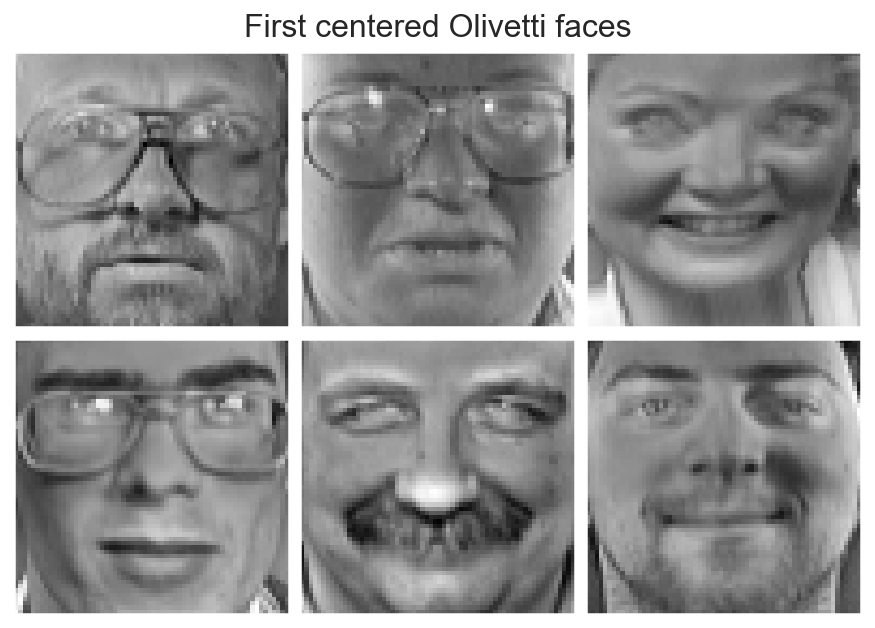

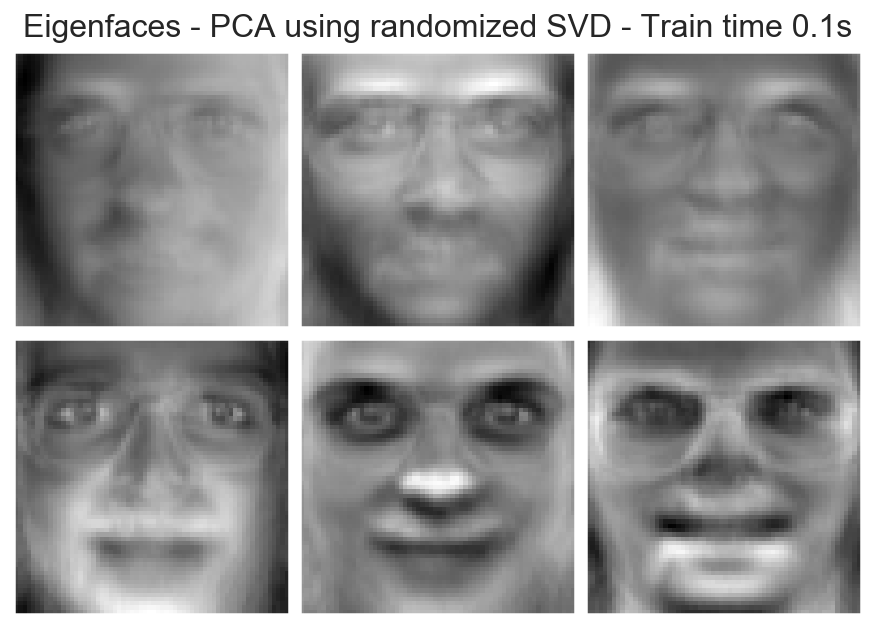

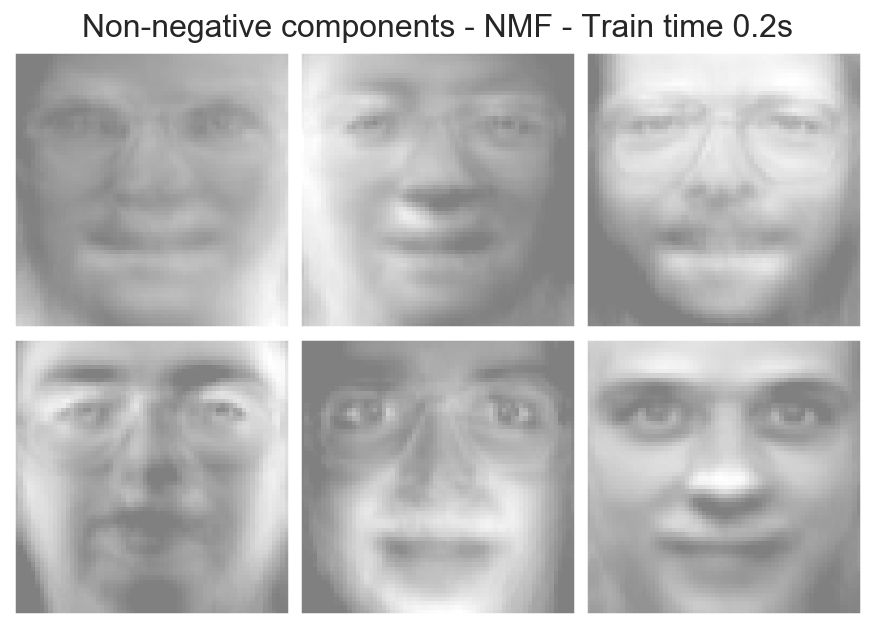

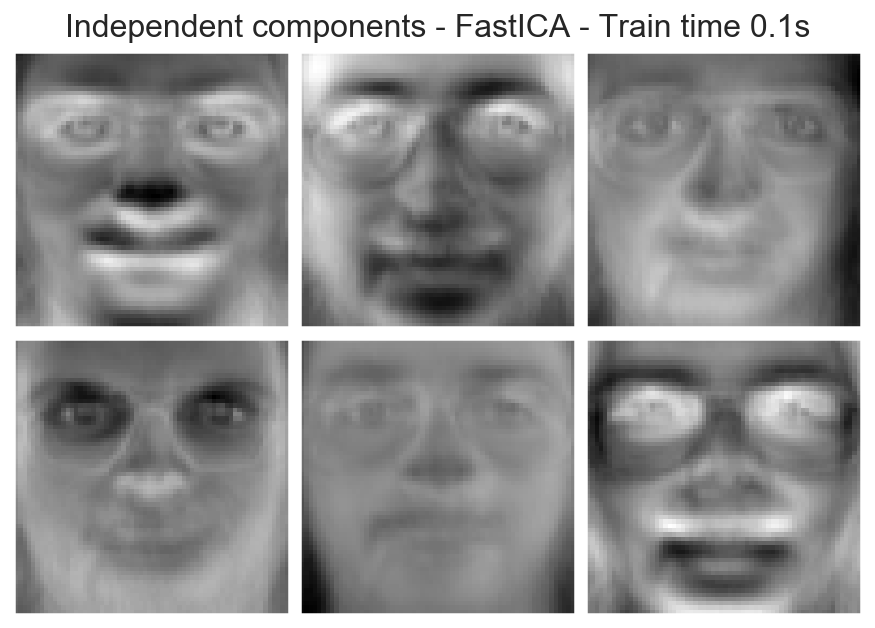

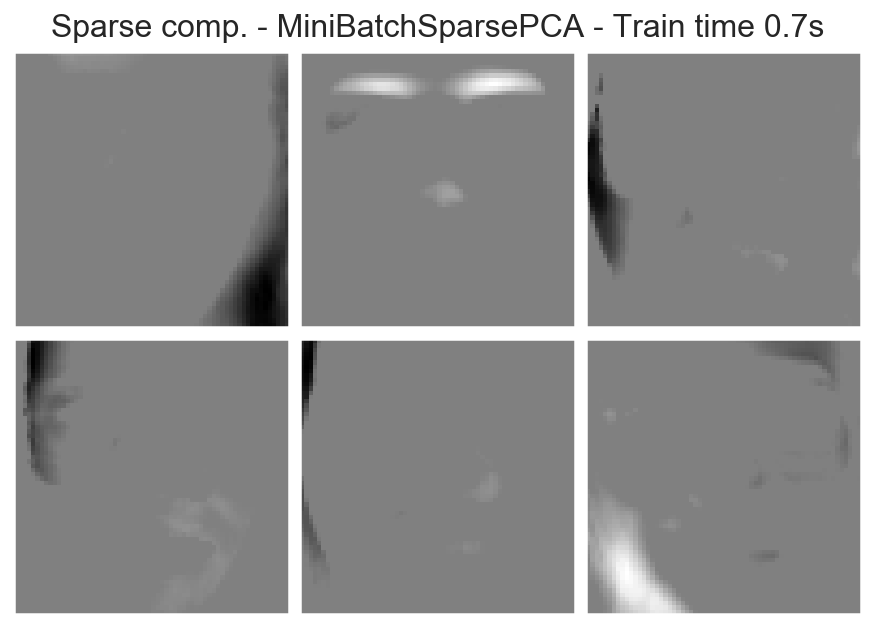

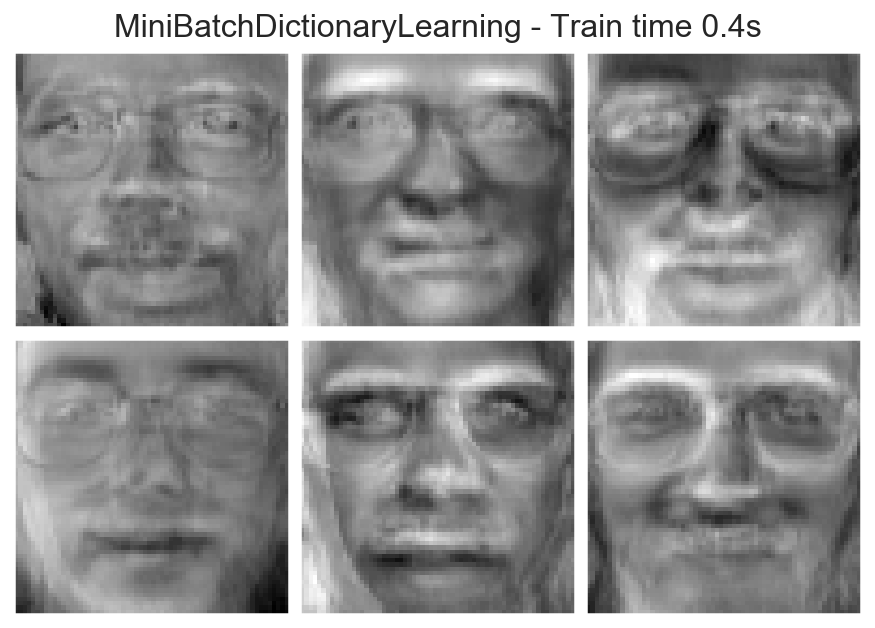

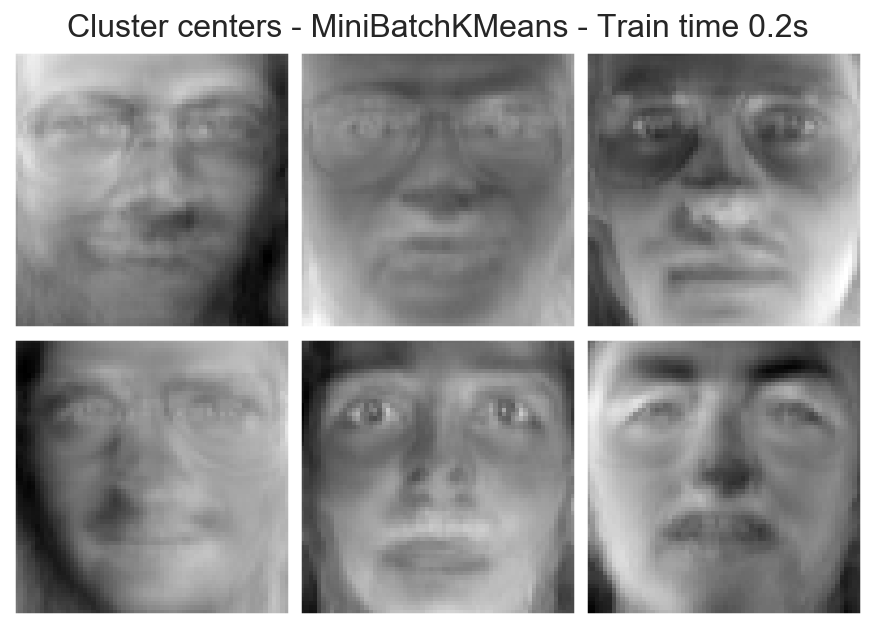

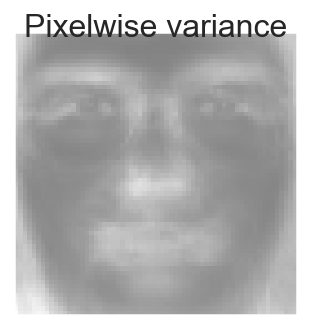

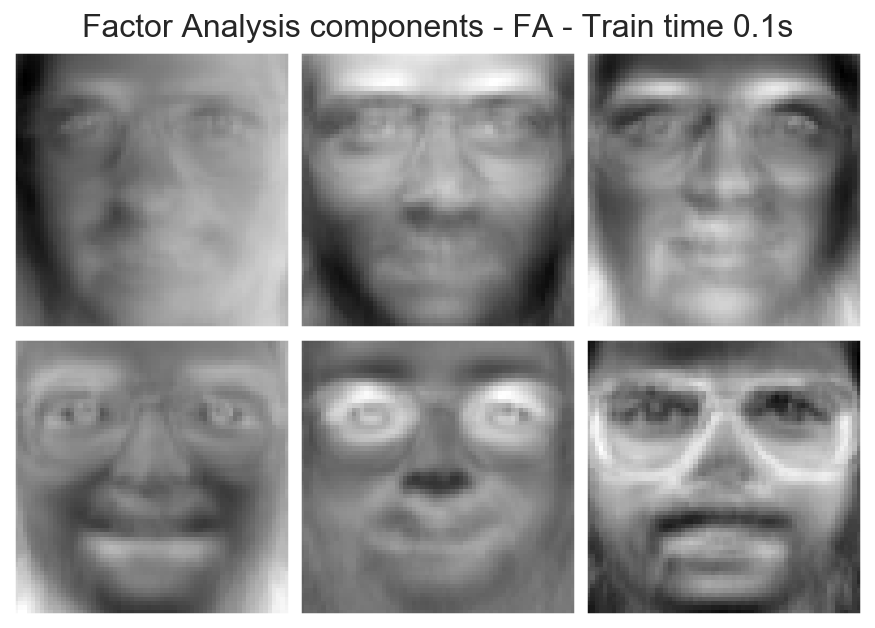

Extracting the top 6 Dictionary learning...
done in 0.423s
Extracting the top 6 Dictionary learning - positive dictionary...
done in 0.416s
Extracting the top 6 Dictionary learning - positive code...
done in 0.113s
Extracting the top 6 Dictionary learning - positive dictionary & code...
done in 0.163s


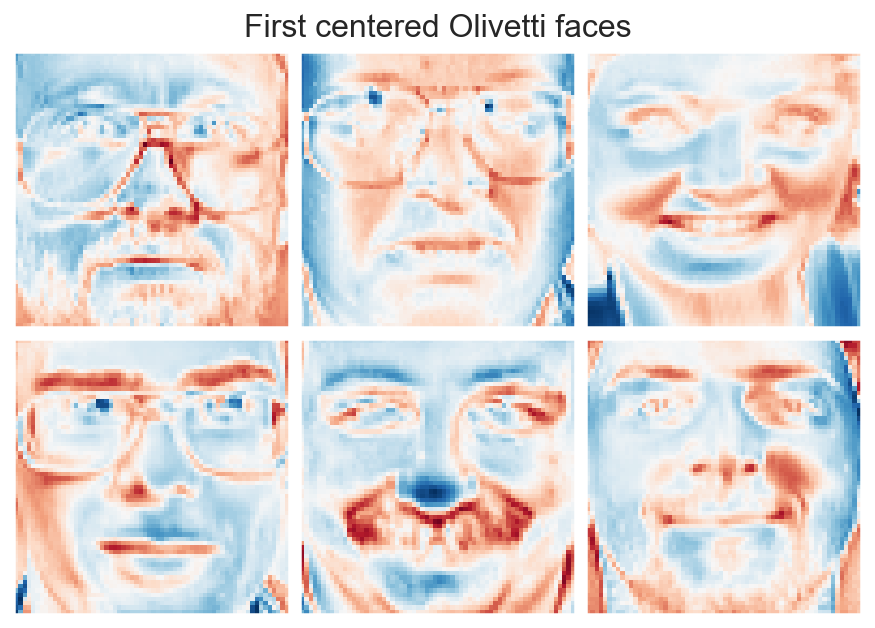

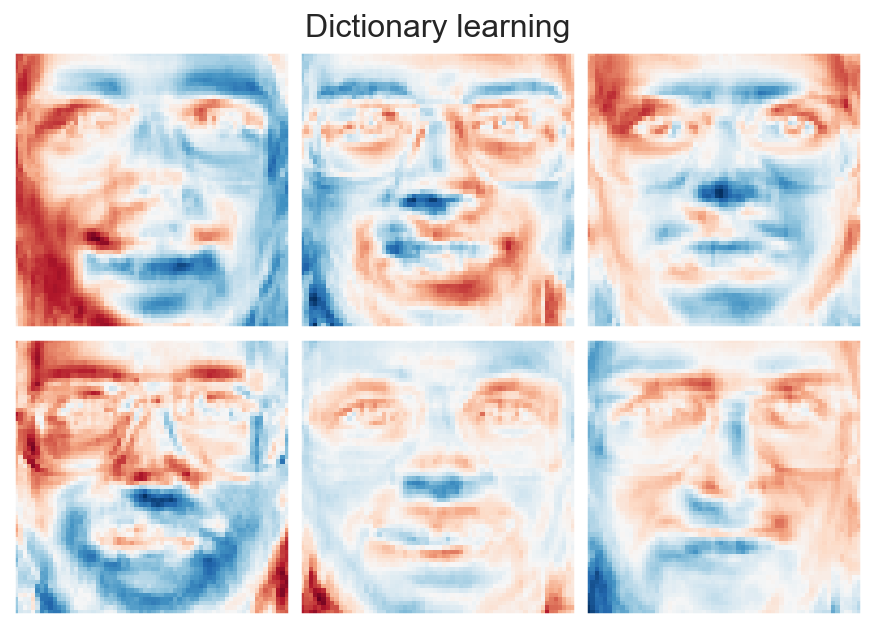

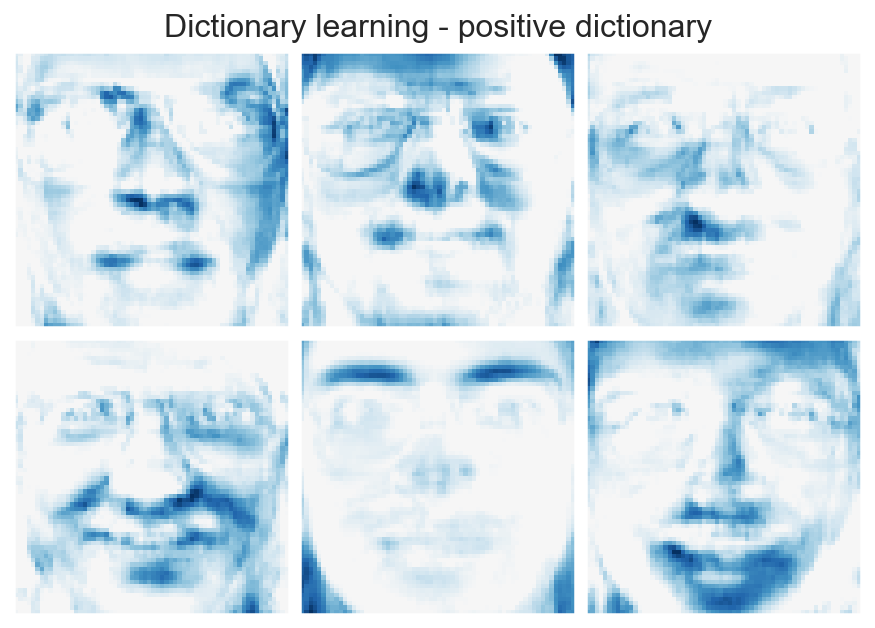

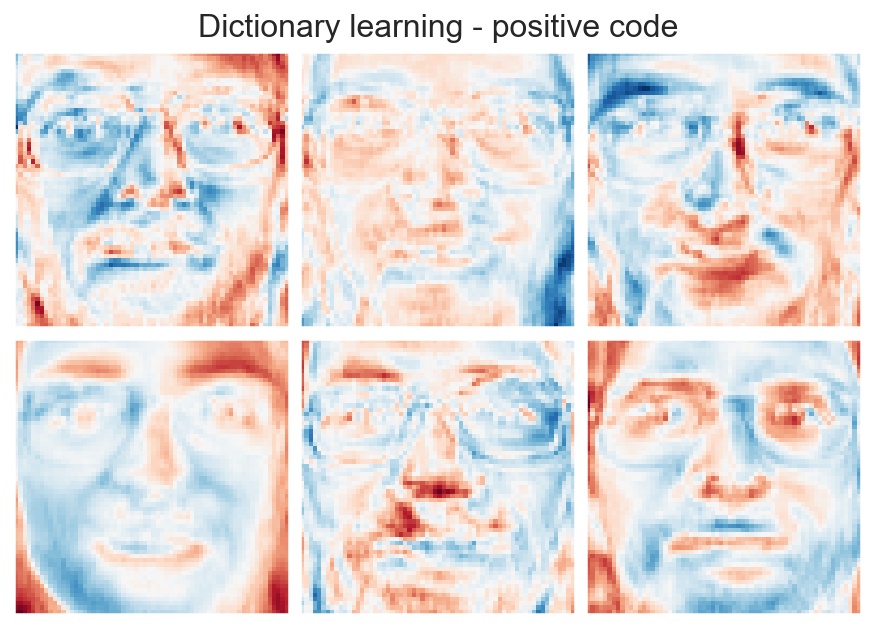

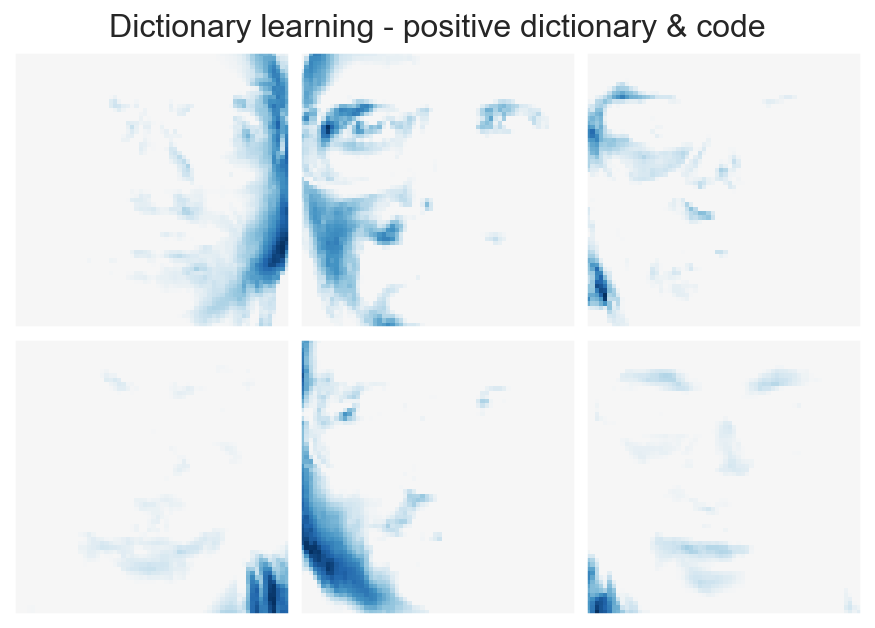

In [51]:
import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=rng)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=20),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

# #############################################################################
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    ('Dictionary learning - positive code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  fit_algorithm='cd',
                                                  random_state=rng,
                                                  positive_code=True),
     True),
    ('Dictionary learning - positive dictionary & code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  fit_algorithm='cd',
                                                  random_state=rng,
                                                  positive_dict=True,
                                                  positive_code=True),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components],
             cmap=plt.cm.RdBu)

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], cmap=plt.cm.RdBu)

plt.show()